In [1]:
import numpy as np
import json
import glob
import os
import matplotlib.pyplot as plt

# Get list of all JSON files in json_data folder
json_files = glob.glob('/scratch/ty296/json_data/*.json')
# Extract just the filenames without path
json_filenames = [os.path.basename(f) for f in json_files]

# Read each JSON file
json_data = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
        json_data.append(data)



Parameters:
L = 10, ancilla = 0, p_ctrl = 0.2222222222222222, p_proj = 0.0
Number of samples: 50
EE values: [1.8889372703689031, 2.0973902391615495, 2.1675261323246118, 1.9971703472155953, 0.875668263417927, 1.9294417683822198, 1.9509953897601275, 1.898105584079855, 2.163085633446559, 1.8783296020102354, 1.3213924456384496, 1.606681455187735, 2.1803958842827407, 2.02513371889208, 1.7477564815692848, 2.0627027869037966, 2.0459340835730275, 1.9229725034177159, 1.885671760355826, 1.9493003500302413, 1.1692372008603462, 1.9683645986271423, 2.004100488167007, 2.1063158479430295, 1.562851058992309, 2.1786875471412923, 1.7238795243300167, 1.7415867770813191, 1.8864032813096787, 1.9482662439686242, 1.867206304257835, 2.134125061715523, 1.848813095752993, 1.5336522716623604, 2.0688669780352043, 1.9406506283597447, 1.826262774836401, 2.017031046778291, 1.4024590446844558, 2.0654518111971933, 1.7384963996325775, 1.8122950058354106, 2.1240762108594113, 1.732045569132418, 1.9573036491373845, 1.912

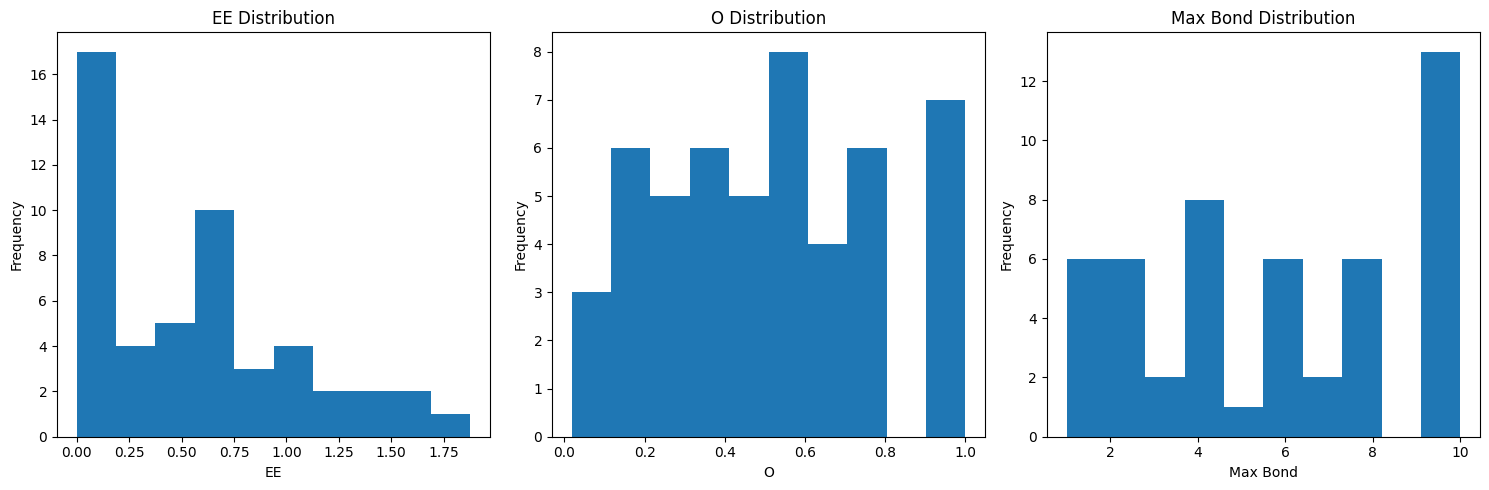


Histograms shown for parameters:
L = 10, ancilla = 0, p_ctrl = 0.5555555555555556, p_proj = 0.0


In [4]:
def group_data_by_params(json_data):
    # Dictionary to store grouped data
    grouped_data = {}
    
    for data in json_data:
        # Create a key tuple with the parameters we want to group by
        key = (
            data['args']['L'],
            data['args']['ancilla'],
            data['p_ctrl'],
            data['p_proj']
        )
        
        # If this parameter combination hasn't been seen before, initialize lists
        if key not in grouped_data:
            grouped_data[key] = {
                'EE': [],
                'O': [],
                'max_bond': []
            }
        
        # Append the values to their respective lists
        grouped_data[key]['EE'].append(data['EE'])
        grouped_data[key]['O'].append(data['O'])
        grouped_data[key]['max_bond'].append(data['max_bond'])
    
    return grouped_data

# Group the data
grouped_results = group_data_by_params(json_data)

# Print results for each parameter combination
for params, values in grouped_results.items():
    L, ancilla, p_ctrl, p_proj = params
    print(f"\nParameters:")
    print(f"L = {L}, ancilla = {ancilla}, p_ctrl = {p_ctrl}, p_proj = {p_proj}")
    print(f"Number of samples: {len(values['EE'])}")
    print(f"EE values: {values['EE']}")
    print(f"O values: {values['O']}")
    print(f"Max bond values: {values['max_bond']}")
    print("-" * 50)

# Example: Plot histograms for a specific parameter set
# Find the first parameter set in our grouped data
example_params = list(grouped_results.keys())[9]
example_data = grouped_results[example_params]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot EE histogram
axes[0].hist(example_data['EE'], bins=10)
axes[0].set_title('EE Distribution')
axes[0].set_xlabel('EE')
axes[0].set_ylabel('Frequency')

# Plot O histogram
axes[1].hist(example_data['O'], bins=10)
axes[1].set_title('O Distribution')
axes[1].set_xlabel('O')
axes[1].set_ylabel('Frequency')

# Plot max_bond histogram
axes[2].hist(example_data['max_bond'], bins=10)
axes[2].set_title('Max Bond Distribution')
axes[2].set_xlabel('Max Bond')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print the parameters for the plotted data
L, ancilla, p_ctrl, p_proj = example_params
print(f"\nHistograms shown for parameters:")
print(f"L = {L}, ancilla = {ancilla}, p_ctrl = {p_ctrl}, p_proj = {p_proj}")


